In [4]:
import os
import json
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
%config InlineBackend.figure_format='retina'


subject = 'HCD0001305'
hemi = 'L'

param_name = 'DKT_MK'


mask      = f'output/sub-{subject}_hemi-{hemi}_space-cropB0_desc-partial_volume.nii.gz'
surf_path = f'output/sub-{subject}_hemi-{hemi}_space-B0_den-0p5mm_label-hipp_inner.surf.gii'
vol_path  = f'output/sub-{subject}_hemi-{hemi}_space-cropB0_desc-kurtosis_sphere-symmetric362.nii.gz'


output_path  = f'output/sub-{subject}_hemi-{hemi}_space-cropB0_desc-{param_name}.{hemi}.func.gii'


In [9]:
radius = 3
sigma_mm = .5


# Load data data.
mask_nii = nib.load(mask)
mask_data = mask_nii.get_fdata()
mask_data_flat = mask_data[mask_data > 0]

vol_nii    = nib.load(vol_path)
vol_data   = vol_nii.get_fdata()
vol_affine = vol_nii.affine

surf       = nib.load(surf_path)
vertex_mm  = surf.darrays[1].data
n_vertices = len(vertex_mm)


# Get coordinates of masked voxels.
voxel_indices = np.column_stack(np.where(mask_data > 0))
voxel_mm = nib.affines.apply_affine(vol_affine, voxel_indices)



362

In [ ]:
# direction_data = []

# # Map voxel data to surface-vertex, weighted by distance and partial-volume.
# voxel_tree = cKDTree(voxel_mm)

# n_directions = vol_data.shape[-1]
# for direction in range(n_directions):

#     print(direction)

#     # Get masked-voxel data.
#     n_voxels = len(voxel_indices)
#     voxel_data = np.full(n_voxels, np.nan)

#     for idx, voxel_idx in enumerate(voxel_indices):
#         x, y, z = voxel_idx
#         voxel_data[idx] = vol_data[x, y, z, direction]


#     vertex_values = np.full(n_vertices, np.nan)
#     for v_idx, vertex in enumerate(vertex_mm):

#         nearby_vox = voxel_tree.query_ball_point(vertex,r=radius)

#         nearby_vox_coords = voxel_mm[nearby_vox]
#         distances = np.linalg.norm(nearby_vox_coords - vertex, axis=1)

#         # Voxels weighted by partial-volume and gaussian-weighted distance.
#         distance_W = np.exp(-0.5 * (distances / sigma_mm)**2)
#         partial_volume_W = mask_data_flat[nearby_vox]
#         W = distance_W * partial_volume_W

#         vertex_values[v_idx] = np.average(voxel_data[nearby_vox], weights=W)

#     direction_data.append(vertex_values)




# intent = nib.nifti1.intent_codes['NIFTI_INTENT_NONE']
# if hemi == 'L': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusLeft'})
# if hemi == 'R': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusRight'})

# darrays = []
# for data in direction_data:
#     darray = nib.gifti.GiftiDataArray(np.array(data, dtype='float32'), intent=intent)
#     darray.meta = nib.gifti.GiftiMetaData({'Name':''})
#     darrays.append(darray)

# gii = nib.GiftiImage(darrays=darrays, meta=meta)
# nib.save(gii, 'direcions.L.func.gii')


In [ ]:
import pandas as pd
from dipy.data import get_sphere
from dipy.reconst import dki, dki_micro


# Get directions of sphere.
sphere_name = 'symmetric362'
sphere = get_sphere(name=sphere_name)
theta = sphere.theta
phi = sphere.phi

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

sphere_dirs  = np.stack([x, y, z], axis=1)
n_directions = len(sphere_dirs)


# For voxels within mask, estimate compartment- and direction- specific diffusion.

for hemi in ['L','R']:

    params_nii = nib.load(f'output/sub-{subject}_hemi-{hemi}_space-cropB0_desc-DKT_params.nii.gz')
    params = params_nii.get_fdata()

    awf        = np.zeros(len(voxel_indices))                  # Axonal water fracion
    extra_diff = np.zeros([len(voxel_indices), n_directions])  # Extra-cellular diffusion.
    intra_diff = np.zeros([len(voxel_indices), n_directions])  # Intra-cellular diffusion.

    for n, voxel_idx in enumerate(voxel_indices):

        x, y, z = voxel_idx
        voxel_params = params[x,y,z,:]

        extra_tensor, intra_tensor = dki_micro.diffusion_components(voxel_params)

        awf[n] = dki_micro.axonal_water_fraction(voxel_params)
        extra_diff[n,:] = dki.directional_diffusion(extra_tensor, sphere_dirs)
        intra_diff[n,:] = dki.directional_diffusion(intra_tensor, sphere_dirs)

    np.save(f'output_model/sub-{subject}_hemi-{hemi}_sphere-{sphere_name}_desc-intra_diffusion.npy', intra_diff)
    np.save(f'output_model/sub-{subject}_hemi-{hemi}_sphere-{sphere_name}_desc-extra_diffusion.npy', extra_diff)
    np.save(f'output_model/sub-{subject}_hemi-{hemi}_sphere-{sphere_name}_desc-awf.npy', awf)



# Get directions of surface-normals.
surf_normals_df = pd.read_csv(f'output/sub-{subject}_hemi-{hemi}_space-B0_label-inner_desc-surface_normals.csv')
surf_normals = surf_normals_df[['x','y','z']].to_numpy()

# Calculate difference in angle between sphere-directions and surface-normals.
angle_diffs = np.zeros([len(sphere_dirs), len(surf_normals)])

for sphere_idx, sphere_dir in enumerate(sphere_dirs):
    for normal_idx, normal_dir in enumerate(surf_normals):

        cos_theta = np.clip(np.dot(sphere_dir, normal_dir), -1, 1)
        angle_diffs[sphere_idx, normal_idx] = np.arccos(cos_theta) * 180/np.pi


# Group surface-sphere angle differences as either normal or tangential.
vertex_angle_labels = []
for vertex in range(len(surf_normals)):

    angle_label = np.zeros(len(sphere_dirs), dtype='<U10')

    normal     = (angle_diffs[:,vertex] <= 45) | (angle_diffs[:,vertex] >= 135)
    tangential = (angle_diffs[:,vertex] >= 45) & (angle_diffs[:,vertex] <= 135)

    angle_label[normal] = 'normal'
    angle_label[tangential] = 'tangential'

    vertex_angle_labels.append(angle_label)

vertex_angle_labels = np.array(vertex_angle_labels)
np.save(f'output_model/sub-{subject}_hemi-{hemi}_sphere-{sphere_name}_desc-surface_sphere_angle_labels.npy', vertex_angle_labels)


In [ ]:
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

subject     = 'HCD0001305'
hemi        = 'L'
sphere_name = 'symmetric362'

sigma_mm = 2
radius_mm = 6


surf_path            = f'output/sub-{subject}_hemi-{hemi}_space-B0_den-0p5mm_label-hipp_inner.surf.gii'
pvol_path            = f'output/sub-{subject}_hemi-{hemi}_space-cropB0_desc-partial_volume.nii.gz'
vertex_sphere_angles = np.load(f'output_model/sub-{subject}_hemi-{hemi}_sphere-{sphere_name}_desc-surface_sphere_angle_labels.npy')
vox_extra_diff       = np.load(f'output_model/sub-{subject}_hemi-{hemi}_sphere-symmetric362_desc-extra_diffusion.npy')
vox_intra_diff       = np.load(f'output_model/sub-{subject}_hemi-{hemi}_sphere-symmetric362_desc-intra_diffusion.npy')
awf                  = np.load(f'output_model/sub-{subject}_hemi-{hemi}_sphere-symmetric362_desc-awf.npy')


surf       = nib.load(surf_path)
vertex_mm  = surf.darrays[1].data

n_vertices   = vertex_sphere_angles.shape[0]
n_directions = vertex_sphere_angles.shape[1]


# Get coordinates of masked voxels.
mask_nii = nib.load(pvol_path)
mask_data = mask_nii.get_fdata()
mask_affine = mask_nii.affine
mask_data_flat = mask_data[mask_data > 0]

voxel_indices = np.column_stack(np.where(mask_data > 0))
voxel_mm = nib.affines.apply_affine(mask_affine, voxel_indices)



voxel_tree = cKDTree(voxel_mm)

vertex_values = {
    'awf':np.full(n_vertices, np.nan),
    'intra_normal':np.full(n_vertices, np.nan),
    'intra_tangential':np.full(n_vertices, np.nan),
    'extra_normal':np.full(n_vertices, np.nan),
    'extra_tangential':np.full(n_vertices, np.nan)
}

for idx, mm in enumerate(vertex_mm):

    # Find nearby voxels (within radius).
    nearby_vox = voxel_tree.query_ball_point(mm, r=radius_mm)
    nearby_vox_coords = voxel_mm[nearby_vox]
    nearby_vox_distances = np.linalg.norm(nearby_vox_coords - mm, axis=1)

    # Get voxel weights based on partial-volume and gaussian-weighted distance.
    distance_W = np.exp(-0.5 * (nearby_vox_distances / sigma_mm)**2)
    partial_volume_W = mask_data_flat[nearby_vox]
    W = distance_W * partial_volume_W

    vertex_values[f'awf'][idx] = np.average(awf[nearby_vox], weights=W)

    # For all nearby voxels, calculate the mean diffusion in the specified directions.
    for label in ['normal','tangential']:

        # Get directions on sphere aligned with 'label'.
        include_dirs = np.argwhere(vertex_sphere_angles[idx,:] == label).flatten()

        dir_intra_diff = vox_intra_diff[nearby_vox,:][:,include_dirs].mean(axis=1)
        dir_extra_diff = vox_extra_diff[nearby_vox,:][:,include_dirs].mean(axis=1)

        vertex_values[f'intra_{label}'][idx] = np.average(dir_intra_diff, weights=W)
        vertex_values[f'extra_{label}'][idx] = np.average(dir_extra_diff, weights=W)


# Write vertex-wise model outputs to binary.
with open(f'output_model/sub-{subject}_hemi-{hemi}_desc-model_params.{hemi}.pkl','wb') as file:
    pickle.dump(vertex_values, file)


# Write vertex-wise model outputs to GIFTI.
intent = nib.nifti1.intent_codes['NIFTI_INTENT_NONE']
if hemi == 'L': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusLeft'})
if hemi == 'R': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusRight'})

darrays = []
for map_name, data in vertex_values.items():
    darray = nib.gifti.GiftiDataArray(np.array(data, dtype='float32'), intent=intent)
    darray.meta = nib.gifti.GiftiMetaData({'Name':map_name})
    darrays.append(darray)

gii = nib.GiftiImage(darrays=darrays, meta=meta)
nib.save(gii, f'output_model/sub-{subject}_hemi-{hemi}_desc-model_params.{hemi}.func.gii')


In [ ]:
import pickle

with
vertex_values

{'awf': array([0.28133134, 0.23514037, 0.2344804 , ..., 0.21181973, 0.21188356,
        0.21190541], shape=(7262,)),
 'intra_normal': array([0.00023871, 0.00014794, 0.00011552, ..., 0.00020232, 0.00018837,
        0.00017462], shape=(7262,)),
 'intra_tangential': array([0.00020401, 0.00016775, 0.00018068, ..., 0.00015855, 0.00016775,
        0.00017507], shape=(7262,)),
 'extra_normal': array([0.00119291, 0.0012042 , 0.00120448, ..., 0.00115369, 0.00113544,
        0.00110847], shape=(7262,)),
 'extra_tangential': array([0.0011874 , 0.0011906 , 0.00117401, ..., 0.00112324, 0.00112157,
        0.00112687], shape=(7262,))}

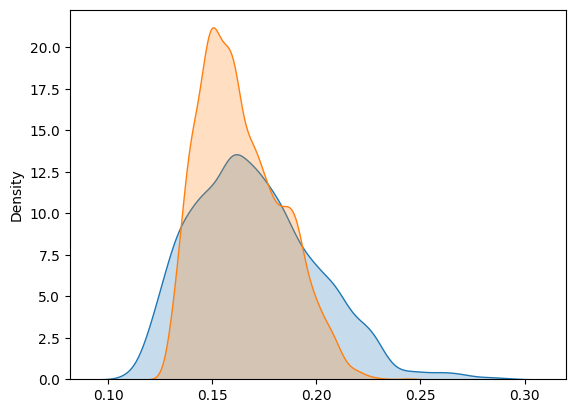

In [117]:
import seaborn as sns

sns.kdeplot(1e3*vertex_values['intra_normal'], fill=True)
sns.kdeplot(1e3*vertex_values['intra_tangential'], fill=True)



intent = nib.nifti1.intent_codes['NIFTI_INTENT_NONE']
if hemi == 'L': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusLeft'})
if hemi == 'R': meta = nib.gifti.GiftiMetaData({'AnatomicalStructurePrimary':'HippocampusRight'})

darrays = []
for map_name, data in vertex_values.items():
    darray = nib.gifti.GiftiDataArray(np.array(data, dtype='float32'), intent=intent)
    darray.meta = nib.gifti.GiftiMetaData({'Name':map_name})
    darrays.append(darray)

gii = nib.GiftiImage(darrays=darrays, meta=meta)
nib.save(gii, 'direction_diffusion.L.func.gii')



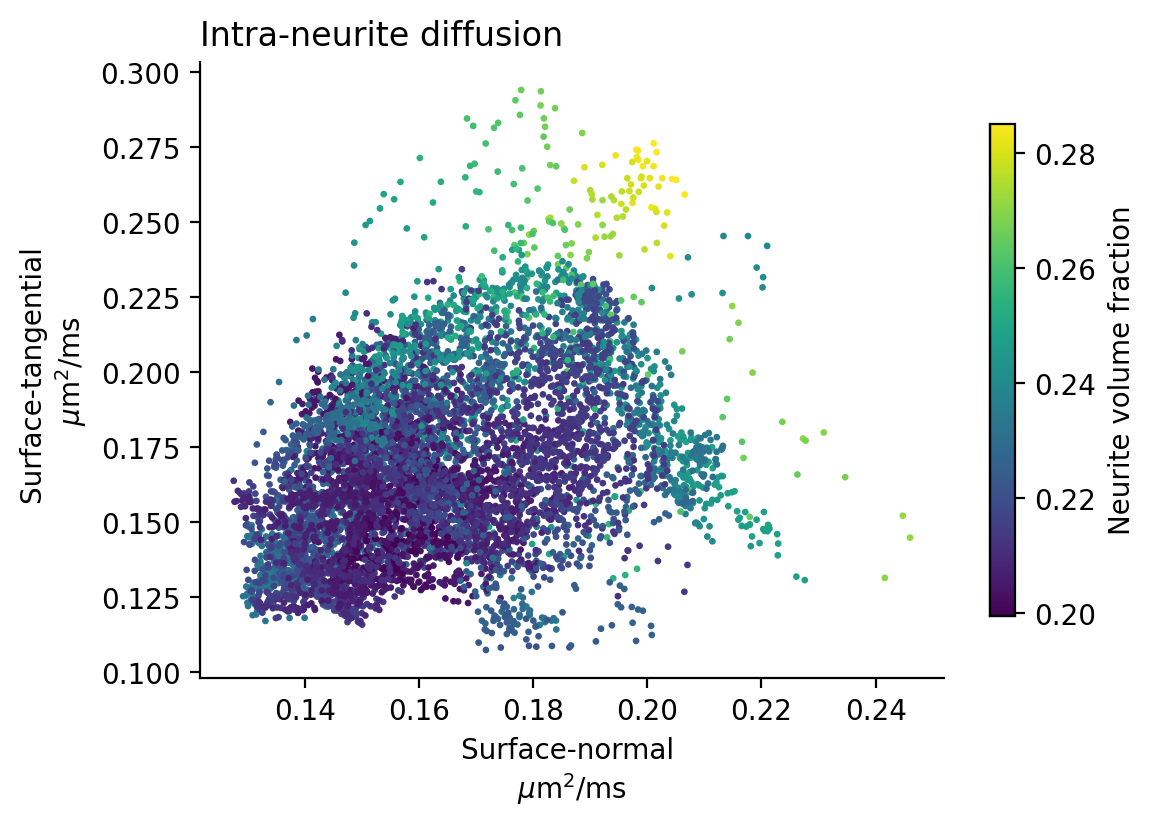

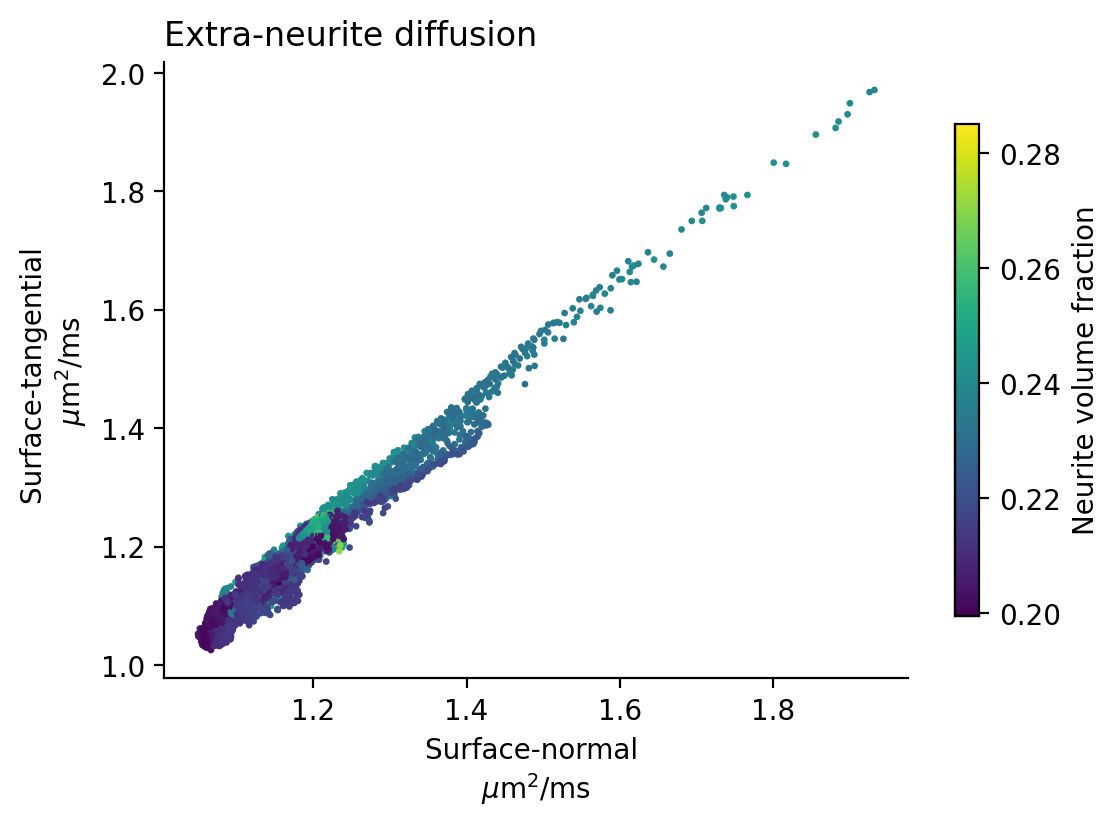

In [196]:

%config InlineBackend.figure_format='retina'

# plt.scatter(
#     vertex_values['intra_tangential']*1e3,
#     vertex_values['intra_normal']*1e3, c=vertex_values['awf'], s=2
# )

# plt.scatter(
#     vertex_values['extra_tangential']*1e3,
#     vertex_values['extra_normal']*1e3, 1
# )

fig, ax = plt.subplots(figsize=(6, 4))

plt.scatter(
    vertex_values['intra_tangential']*1e3,
    vertex_values['intra_normal']*1e3,c=vertex_values['awf'], s=2
)
plt.colorbar(label='Neurite volume fraction', shrink=.8)
ax.set_title('Intra-neurite diffusion', loc='left')
ax.set_xlabel('Surface-normal \n$μ$m$^2$/ms', fontsize=10)
ax.set_ylabel('Surface-tangential \n$μ$m$^2$/ms', fontsize=10)
sns.despine()


fig, ax = plt.subplots(figsize=(6, 4))

plt.scatter(
    vertex_values['extra_tangential']*1e3,
    vertex_values['extra_normal']*1e3,c=vertex_values['awf'], s=2
)
plt.colorbar(label='Neurite volume fraction', shrink=.8)
ax.set_title('Extra-neurite diffusion', loc='left')
ax.set_xlabel('Surface-normal \n$μ$m$^2$/ms', fontsize=10)
ax.set_ylabel('Surface-tangential \n$μ$m$^2$/ms', fontsize=10)
sns.despine()


In [185]:
np.cov(vertex_values['intra_tangential'], vertex_values['intra_normal'])[0,1]


import pingouin as pg

pg.ttest(
    vertex_values['extra_tangential'],
    vertex_values['extra_normal']
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.967745,14522,two-sided,0.000073,"[-0.0, -0.0]",0.065846,48.469,0.977653
